In [31]:
# !pip install catboost
# !pip install pycaret
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime as dt
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns

#-------------------- 주피터 셀 넓이 조절 ---------------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', None)


In [2]:
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams["figure.figsize"] = (8,4)
mpl.rcParams['axes.grid'] = True 
path = 'C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
# plt.title('한글제목')
# plt.show()


NanumGothic


In [4]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

### 변수 간 관계 시각화

In [5]:
# 일-석식계 간 관계
# plt.figure(figsize=(12,6))
# sns.boxplot(train['일'], train['석식계'])

In [ ]:
#주-석식계 간 관계
# plt.figure(figsize=(20,6))
# sns.boxplot(train['주'], train['석식계'])

In [ ]:
#월-석식계 간 관계
# plt.figure(figsize=(12,6))
# sns.boxplot(train['월'], train['석식계'])

In [ ]:
#년도-석식계 간 관계
# plt.figure(figsize=(12,6))
# sns.boxplot(train['년'], train['석식계'])

In [32]:
import re 
text = ' 쌀밥 /잡곡밥 (쌀,현미흑미:국내산) 오징어찌개  쇠불고기 쇠고기:호주산) 계란찜  청포묵무침  요구르트  포기김치 (배추,고추가루:국내산) '
text = re.sub(r'/^\s+|\s+$/g', '', text.strip())#앞뒤 공백 제거
text = text.replace(r' /','/')  #앞뒤 공백 제거
text = text.replace(r'/ ','/')  #앞뒤 공백 제거
  
list = text.split()
relist = []
for item in list:
    item = re.sub(r'\([^)]*\)', '', item.strip())  #(s) 제거
    item = re.sub(r'[^)]*\)', '', item.strip())    #s) 제거
    item = re.sub(r'\([^)]*', '', item.strip())    #(s 제거
    item = re.sub(' +', ' ', item.strip())       #공백,탭 제거
    if len(item) > 0:
        relist.append(item)
print(list)
print(relist)

['쌀밥/잡곡밥', '(쌀,현미흑미:국내산)', '오징어찌개', '쇠불고기', '쇠고기:호주산)', '계란찜', '청포묵무침', '요구르트', '포기김치', '(배추,고추가루:국내산)']
['쌀밥/잡곡밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치']


* 정규표현식
<pre>
특정문자 제거            : str.replace(/\-/g,'');
앞의 공백 제거           : str.replace(/^\s+/,'');
뒤의 공백 제거          : str.replace(/\s+$/,'');
앞뒤 공백 제거          : str.replace(/^\s+|\s+$/g,'');
문자열 내의 공백 제거  : str.replace(/\s/g,'');
개행 제거                : str.replace(/\n/g,'');
엔터 제거                : str.replace(/\r/g,'');
0 제거                   : str.replace(/[^(1-9)]/gi,"");

In [190]:
# re.sub(r'[^(소고기)]/g', 'ㅁ', '매운소고기무국'.strip())    # 양배추 뒤 제거     


'매운소고기무국'

In [170]:
def reg_exclude_(text):
    text = re.sub(r'/^\s+|\s+$/g', '', text.strip())#앞뒤 공백 제거
    text = text.replace(r' /','/')  #앞뒤 공백 제거
    text = text.replace(r'/ ','/')  #앞뒤 공백 제거

    list = text.split()
    relist = []
    for item in list:
        item = re.sub(r'\([^)]*\)', '', item.strip())               #(s) 제거
        item = re.sub(r'\/.+?$', '', item.strip())                  # /s 제거        
        item = re.sub(r'\양배추.+?$', '양배추', item.strip())        # 양배추 뒤 제거   
        item = re.sub(r'\영양밥.+?$', '영양밥', item.strip())        # 콩나물밥 뒤 제거   
        
        item = re.sub(r'\*[^)]*', '', item.strip())                           # * 뒤 제거   
        item = re.sub(r'[^비빔밥]*\비빔밥', '비빔밥', item.strip())             # 비빔밥 앞제거
        item = re.sub(r'[^불고기덮밥]*\불고기덮밥', '고기덮밥', item.strip())    # 고기덮밥 앞제거
        item = re.sub(r'[^영양밥]*\영양밥', '영양밥', item.strip())             # 영양밥 앞제거
        item = re.sub(r'[^볶음밥]*\볶음밥', '볶음밥', item.strip())             # 볶음밥 앞제거
        item = re.sub(r'[^카레라이스]*\카레라이스', '카레라이스', item.strip())  # 카레라이스 앞제거
        item = re.sub(r'[^카레라이스]*\카레라이스', '카레라이스', item.strip())  # 카레라이스 앞제거
        item = re.sub(r'[^콩나물밥]*\콩나물밥', '콩나물밥', item.strip())       # 콩나물밥 앞제거
        item = item.strip().replace('짜장밥', '짜장덮밥')
        item = item.strip().replace('카레라이스', '카레덮밥')
        item = item.strip().replace('김치제육덮밥', '고기덮밥')
        item = item.strip().replace('돈육버섯고추장덮밥', '고기덮밥')
        item = item.strip().replace('김치필라프', '볶음밥') 
        item = item.strip().replace('김치볶음밥', '볶음밥') 
        item = item.strip().replace('김밥볶음밥', '볶음밥')
        
        item = re.sub(r'\소고기[^국]*', '', item.strip())                #소고기 뒤 제거
        
        item = re.sub(r'[^)]*\)', '', item.strip())                #s) 제거
        item = re.sub(r'\([^)]*', '', item.strip())                #(s 제거
        item = re.sub(' +', ' ', item.strip())                     #공백,탭 제거
        if len(item) > 0:
            relist.append(item)
    return ' '.join(relist)
train['중식메뉴2'] = train['중식메뉴'].apply(lambda x: reg_exclude_(x))

In [171]:
 train[['중식메뉴','중식메뉴2']].head()

,중식메뉴,중식메뉴2
0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치
1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)",쌀밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이
2,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)",카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치
3,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치
4,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 청경채무침 요구르트 포기김치 (배추,고추가루:국내산)",쌀밥 떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트 포기김치


In [163]:
lens = [len(row) for row in train['중식메뉴2'].str.split().tolist()]
np.unique(lens)

array([5, 6, 7, 8])

In [172]:
#[['bab', 'soup', 'kimchi', 'menu1', 'menu2', 'menu3', 'menu4']]
menu = pd.DataFrame(train['중식메뉴2'].str.split().tolist(), columns=["m1","m2","m3","m4","m5","m6","m7","m8"])
print(menu.shape)
menu.head()


(1205, 8)


,m1,m2,m3,m4,m5,m6,m7,m8
0,쌀밥,오징어찌개,쇠불고기,계란찜,청포묵무침,요구르트,포기김치,None
1,쌀밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,요구르트,배추겉절이,None
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,요구르트,포기김치,None
3,쌀밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,요구르트,포기김치,None
4,쌀밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,요구르트,포기김치,None


In [173]:
menu['m1'].unique() 

array(['쌀밥', '카레덮밥', '비빔밥', '곤드레밥', '콩나물밥', '영양밥', '볶음밥', '참치회덮밥',
       '연복풍덮밥', '고기덮밥', '짜장덮밥', '오곡밥', '<초복특식>', '삼계탕', '마파두부덮밥', '오므라이스'],
      dtype=object)

In [205]:
menu[~menu['m6'].isna()].tail(100)

,m1,m2,m3,m4,m5,m6,m7,m8
1105,쌀밥,시금치된장국,카레닭찜,김치빈대떡,고구마순볶음,포기김치,시리얼&요거트,None
1106,쌀밥,나주곰탕,적어구이&양념장,한식잡채,얼갈이나물,석박지,그린샐러드,None
1107,쌀밥,다슬기아욱국,돈사태김치찜,닭살겨자냉채,삼색유자청무침,열무김치,모닝샌드,None
1108,쌀밥,순두부찌개,소불고기,코다리강정,노각생채,포기김치,견과류샐러드,None
1109,쌀밥,황태콩나물해장국,궁보계정,시금치프리타타,가지고추장무침,포기김치,양상추샐러드,None
1110,쌀밥,우거지국,매콤돼지갈비찜,삼색만두채소무침,호박채나물볶음,포기김치,황도샐러드,None
1111,쌀밥,오리들깨탕,냉족발야채무침,수제오미산적,부추샐러드,포기김치,꽃맛살샐러드,None
1112,쌀밥,매운계란파국,마파두부,치킨핑거,쫄면채소무침,열무김치,그린샐러드,None
1113,쌀밥,옹심이만두국,대패삽겹숙주볶음,오징어초무침,양배추,포기김치,양상추샐러드,None
1114,쌀밥,아욱된장국,생선까스,마카로니치즈범벅,오이사과무침,포기김치,양상추샐러드,None


In [206]:
menu.drop(['m6','m7','m8'], axis=1, inplace=True)

In [207]:
menu.head()

,m1,m2,m3,m4,m5
0,쌀밥,오징어찌개,쇠불고기,계란찜,청포묵무침
1,쌀밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림
3,쌀밥,쇠고기무국,주꾸미볶음,부추전,시금치나물
4,쌀밥,떡국,돈육씨앗강정,우엉잡채,청경채무침


In [208]:
menu.to_csv("menu.csv")

## NLP
* 2021.06.12 기준
* 메뉴의 종류를 원-핫 인코딩으로 분류시켜서 학습시키니 성능 상승
* '주' 및 '월' 데이터를 추가해서 연초 연말 월초 월말 알아서 학습 유도

In [ ]:
 train['중식메뉴']

#### 메뉴 임베딩

(-0.5, 399.5, 199.5, -0.5)

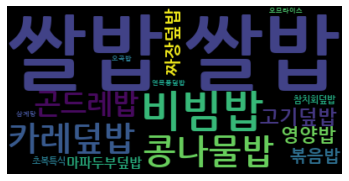

In [223]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()

text = " ".join(menu['m1'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')



(-0.5, 399.5, 199.5, -0.5)

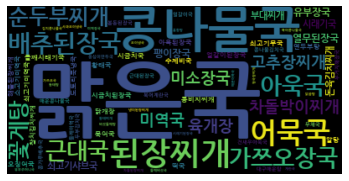

In [222]:
text = " ".join(menu['m2'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

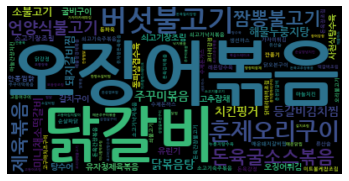

In [219]:
text = " ".join(menu['m3'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

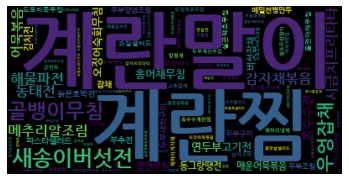

In [220]:
text = " ".join(menu['m4'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

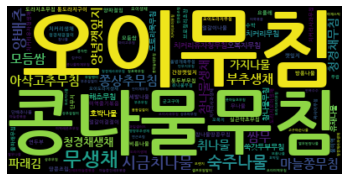

In [221]:
text = " ".join(menu['m5'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

#### 모든 메뉴의 분류

## Feature Engineering
* 문화의날

## 강수량 및 기온 Feature Generating00
* 외부 데이터(기상청) 사용
* 기온 및 강수량에 따라 중식계 영향을 미칠 것으로 예상
* 본거지가 진주가 아닌 사원들이 많아 기숙사 생활 인원이 많음
* 따라서 강수량 및 기온은 크게 영향 미치지 않을 것으로 추정

## 공휴일 전후 데이터 추가
* 테스트 데이터에 설날 연휴, 어린이날 존재
* 연휴 전날 1로 인코딩 나머지 0

In [ ]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

In [ ]:
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] =2
test['공휴일전후'][20] = 1

In [ ]:
# 원핫인코딩
train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

In [ ]:
test['공휴일전후_0'][20] =1
test['공휴일전후_1'][20] = 0

# Train Data Set & Test Data Set
* 데이터 지정
* 중식은 주52시간 탄련근무제에 영향 안받음
* 석식은 591번째 데이터 이후 (2018.07.01) 이후 부터 정의
* 메뉴 데이터 포함


In [ ]:
 -----------------------------<Full DATA>-----------------------------------

train_lunch = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']]
test_lunch = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

train_dinner = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']]
test_dinner = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

# ------------------------<AFTER 2018.07.01 DATA>----------------------------

# train_1 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']][591:]
# test_1 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

# train_2 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']][591:]
# test_2 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

#메뉴
train_lunch = pd.concat([train_lunch, lunch_sort], axis = 1)
train_dinner = pd.concat([train_dinner, dinner_sort], axis = 1)
test_lunch = pd.concat([test_lunch, lunch_sort_t], axis = 1)
test_dinner = pd.concat([test_dinner, dinner_sort_t], axis = 1)
print('done')

## 중식 모델링

In [ ]:
reg = setup(data=train_lunch,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

In [ ]:
best_5_l = compare_models(sort='MAE', n_select=5)

In [ ]:
# 앙상블 모델

blended_l = blend_models(estimator_list= best_5_l, fold=5, optimize='MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_lunch)

In [ ]:
pred_esb_l['Label']

## 제출

In [ ]:
submission_esb = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

In [ ]:
reg = setup(data=train_dinner,
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

In [ ]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)

In [ ]:
# 앙상블 모델

blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_dinner)

pred_esb_d = predict_model(final_model_d, test_dinner)

submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

In [ ]:
# submission_esb.to_csv('submission.csv', index = False)